# Reproduction of Results from Hills et al.

This notebook attempts to reproduce all the results from Hills et al. using the ``edges_estimate`` code, either with ``emcee`` or ``polychord``. 

### Setup

In [1]:
from edges_estimate.likelihoods import MultiComponentSpectrumChi2, Param
from edges_estimate.mcmc import run_mcmc
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate import foregrounds as fg

import numpy as np
import matplotlib.pyplot as plt

import getdist
from getdist import plots, MCSamples

%matplotlib inline

from scipy.stats import norm


%load_ext autoreload
%autoreload 2


ImportError: cannot import name 'MultiComponentSpectrumChi2' from 'edges_estimate.likelihoods' (/home/steven/Documents/Projects/radio/EOR/Edges/edges_estimate/edges_estimate/likelihoods.py)

In [ ]:
def residual_plot(sampler, likelihood, discard=0, thin=1):
    blobs = sampler.get_blobs(discard=discard, thin=thin, flat=True)
    for blob in blobs:
        plt.plot(likelihood.freqs, 1000*(likelihood.data - blob[0]), alpha=0.2, color='k')
    plt.xlabel("Frequency [Mhz]")
    plt.ylabel("Residual [mK]")
    plt.grid(True)

In [ ]:
def traceplot(sampler, likelihood, with_lnl=True):
    chain = sampler.get_chain()

    n = chain.shape[-1]
    if with_lnl: n += 1
        
    nn = min(int(np.sqrt(n)) + 1, n)
    mm = int(n/nn) + 1
    
    fig, ax = plt.subplots(nn,mm, sharex=True, figsize=(mm*5, nn*3), gridspec_kw={"hspace":0.05})
    
    for i, (ch, lbl) in enumerate(zip(chain.T, likelihood.parameters.values())):
        ax.flatten()[i].set_ylabel(lbl.latex, fontsize=14)
        
        for thread in ch:
            ax.flatten()[i].plot(thread, color='k', alpha=0.4)
         
    if with_lnl:
        for thread in sampler.get_log_prob().T:
            ax.flatten()[i+1].plot(thread, color='k', alpha=0.4)
            ax.flatten()[i+1].set_ylabel("Log Likelihood", fontsize=14)
        
    plt.subplots_adjust()

In [ ]:
def corner(sampler, likelihood, discard=0, **kwargs):
    samples = MCSamples(
        samples=sampler.get_chain(flat=False, discard=discard), 
        names = likelihood.parameters.keys(), 
        labels = [p.latex for p in likelihood.parameters.values()]
    )

    g = plots.getSubplotPlotter()
    g.triangle_plot(
        samples, 
        param_limits={k:(samples.mean(k) - 4*samples.std(k), samples.mean(k) + 4*samples.std(k)) 
                      for k in likelihood.parameters.keys()}, 
        **kwargs
    )

In [ ]:
data = np.genfromtxt("figure1_plotdata.csv", skip_header=1, delimiter=',')
freq, tsky = data[data[:,1]>0,0], data[data[:,1]>0,2]

## Linearized Physical

In [7]:
lk_linphys = MultiComponentSpectrumChi2(
    data = tsky,
    components = (
        AbsorptionProfile(freqs=freq),
        fg.PhysicalLin(freqs=freq)
    ),
    params = (
        Param("A", min=0, max=20, ref=norm(0.55, scale=0.1)),
        Param("tau", min=0, max=100, ref=norm(7, scale=1)),
        Param("nu0", min=60, max=90, ref=norm(loc=78, scale=2)),
        Param("w", min=1, max=40, ref=norm(loc=19, scale=2)),
        Param("p0", min=-1e5, max=1e5, ref=norm(loc=-15431, scale=100)),
        Param("p1", min=-1e5, max=1e5, ref=norm(loc=-8213, scale=100)),
        Param("p2", min=-1e5, max=1e6, ref=norm(loc=-2582, scale=100)),
        Param("p3", min=-1e5, max=1e5, ref=norm(loc=200, scale=10)),
        Param("p4", min=-1e5, max=1e5, ref=norm(loc=16981, scale=100)),
    ),
    sigma = 0.01
)

In [11]:
sampler_linphys_emcee = run_mcmc(
    lk_linphys,
    sampler_kw = {"nwalkers":500//2, "threads":8},
    sampling_kw = {"nsteps":3000//3, "store":True, "progress":"notebook"}
)

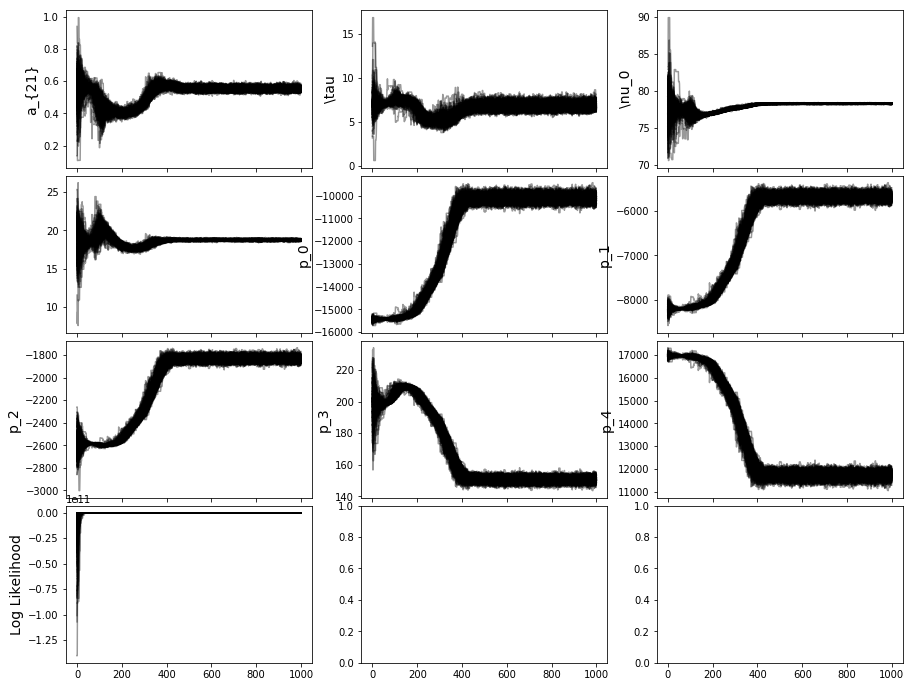

In [12]:
traceplot(sampler_linphys_emcee, lk_linphys)

In [14]:
np.mean(sampler_linphys_emcee.acceptance_fraction), np.std(sampler_linphys_emcee.acceptance_fraction)

(0.423476, 0.01580282962003957)

In [16]:
np.mean(sampler_linphys_emcee.flatchain, axis=0)

array([ 5.25402314e-01,  6.62177944e+00,  7.79567668e+01,  1.86641876e+01,
       -1.17375187e+04, -6.44405963e+03, -2.06719044e+03,  1.67929365e+02,
        1.33201767e+04])

Removed no burn in


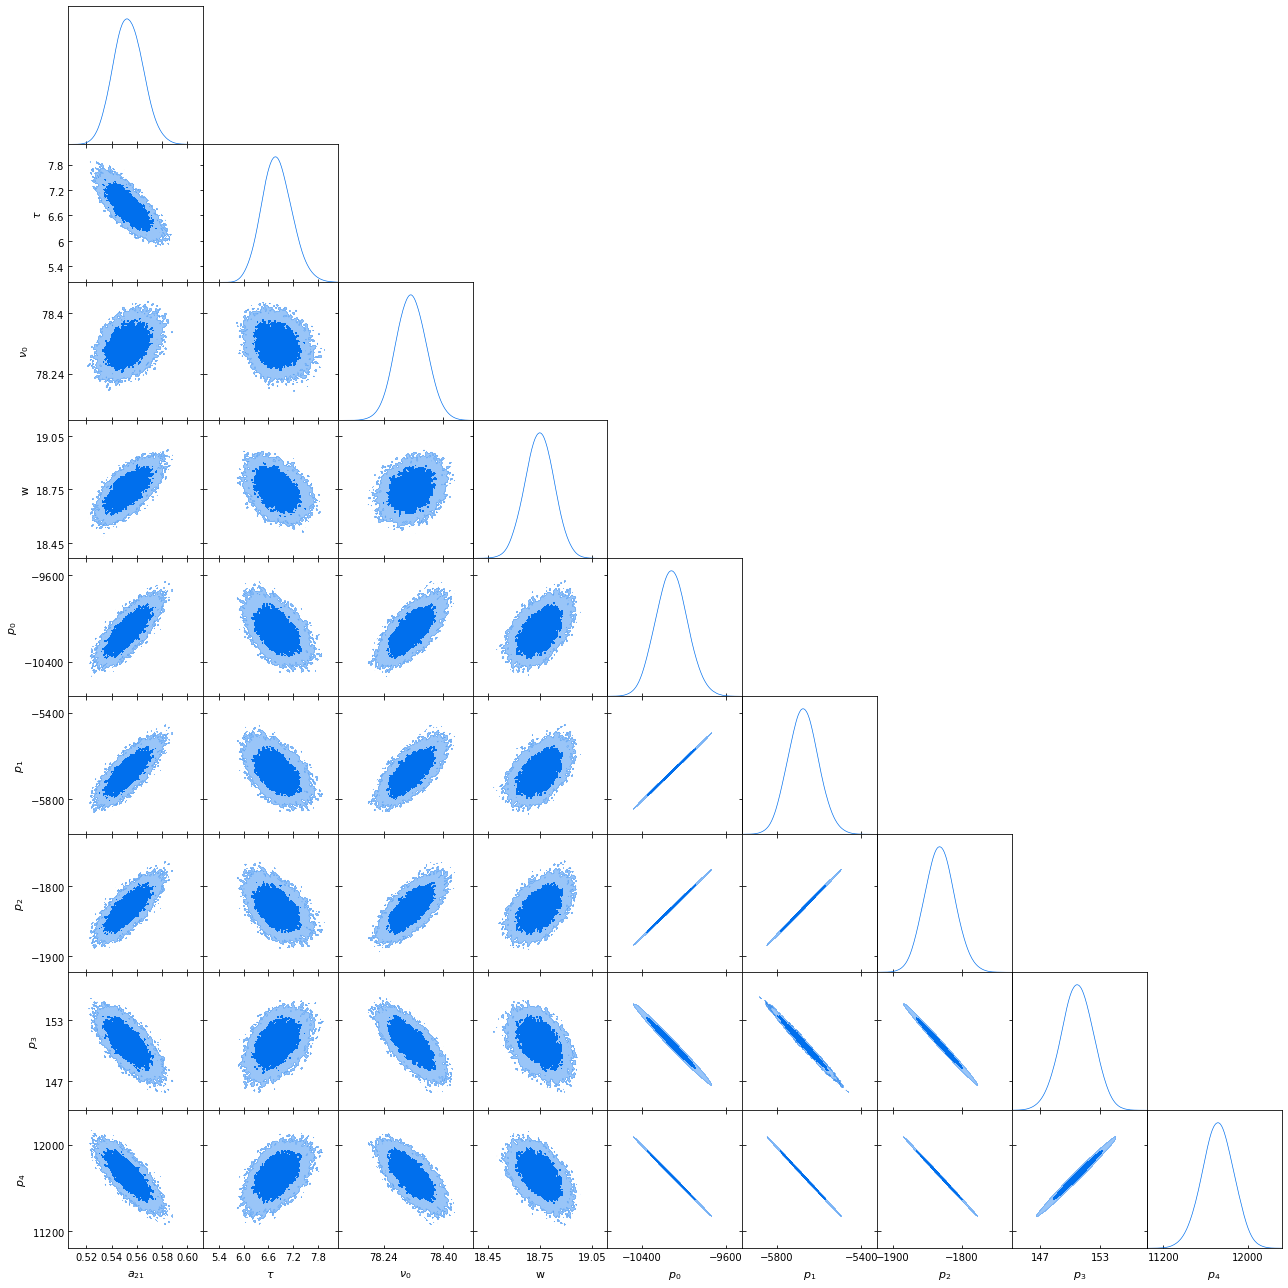

In [20]:
corner(sampler_linphys_emcee, lk_linphys, discard=500, filled=True)

In [8]:
sampler_linphys = run_mcmc(
    lk_linphys, 
    sampler="polychord",
    sampler_kw = {
        "read_resume":True, 
        "base_dir":'HillsChains',
        "file_root":"linphys",
        "nlive":2048
    },
)

/home/steven/.local/lib/python3.7/site-packages/pypolychord-1.16-py3.7-linux-x86_64.egg/pypolychord/output.py:188: FutureWarning: read_table is deprecated, use read_csv instead.
  names= initial_col_names)


HillsChains/linphys.txt
Removed no burn in


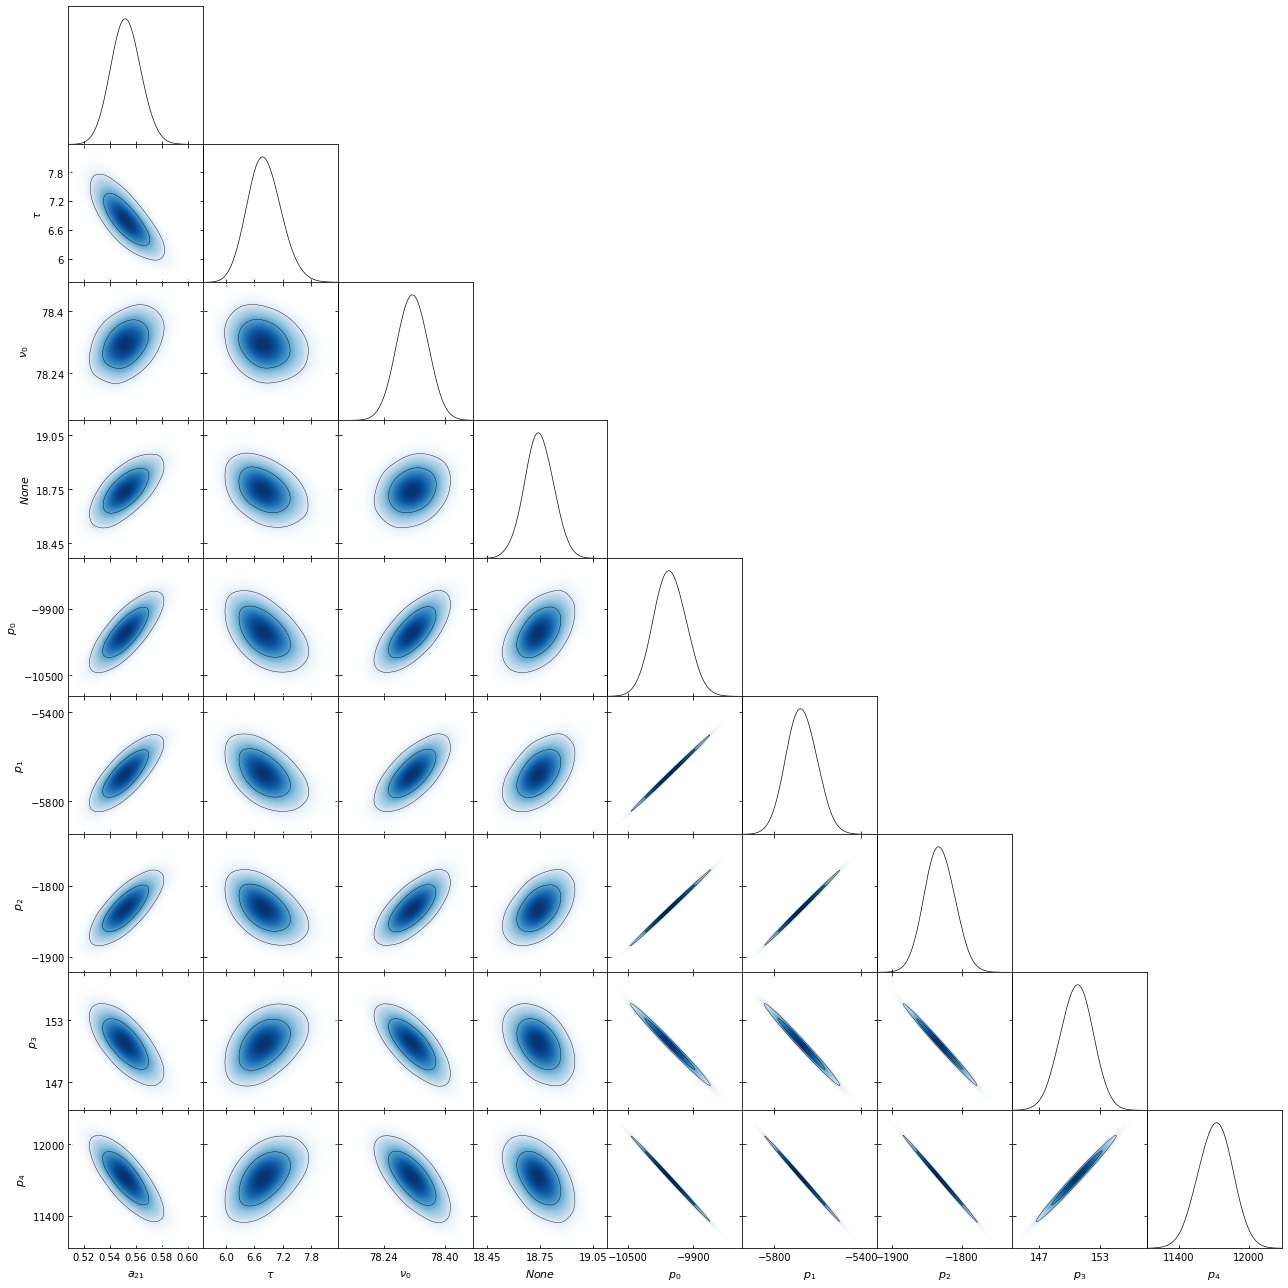

In [22]:
posterior = sampler_linphys.posterior
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(posterior, shaded=True)

## Bowman Physical

In [9]:
lk_phys_broad = MultiComponentSpectrumChi2(
    data = tsky,
    components = (
        AbsorptionProfile(freqs=freq),
        fg.PhysicalSmallIonDepth(freqs=freq)
    ),
    params = (
        Param("A", min=0, max=20, ref=norm(0.54, 0.1)),
        Param("tau", min=0, max=100, ref=norm(6.97, 1)),
        Param("nu0", min=60, max=90, ref = norm(78.34, 3)),
        Param("w", min=1, max=40, ref=norm(18.74, 1)),
        Param("b0", min=1, max=1e4, ref=norm(870,10)),
        Param("b1", min=-10, max=10, ref=norm(-0.36, 0.1)),
        Param("b2", min=-10, max=10, ref=norm(-0.5, 0.1)),
        Param("b3", min=-10, max=10, ref=norm(-0.08, 0.01)),
        Param("b4", min=-10000, max=10000, ref=norm(800, 10)),
    )
)

In [10]:
sampler_phys_broad = run_mcmc(
    lk_phys_broad, 
    sampler_kw = {"nwalkers":500, "threads":8},
    sampling_kw = {"nsteps":3000, "store":True, "progress":"notebook"}
)

Removed no burn in


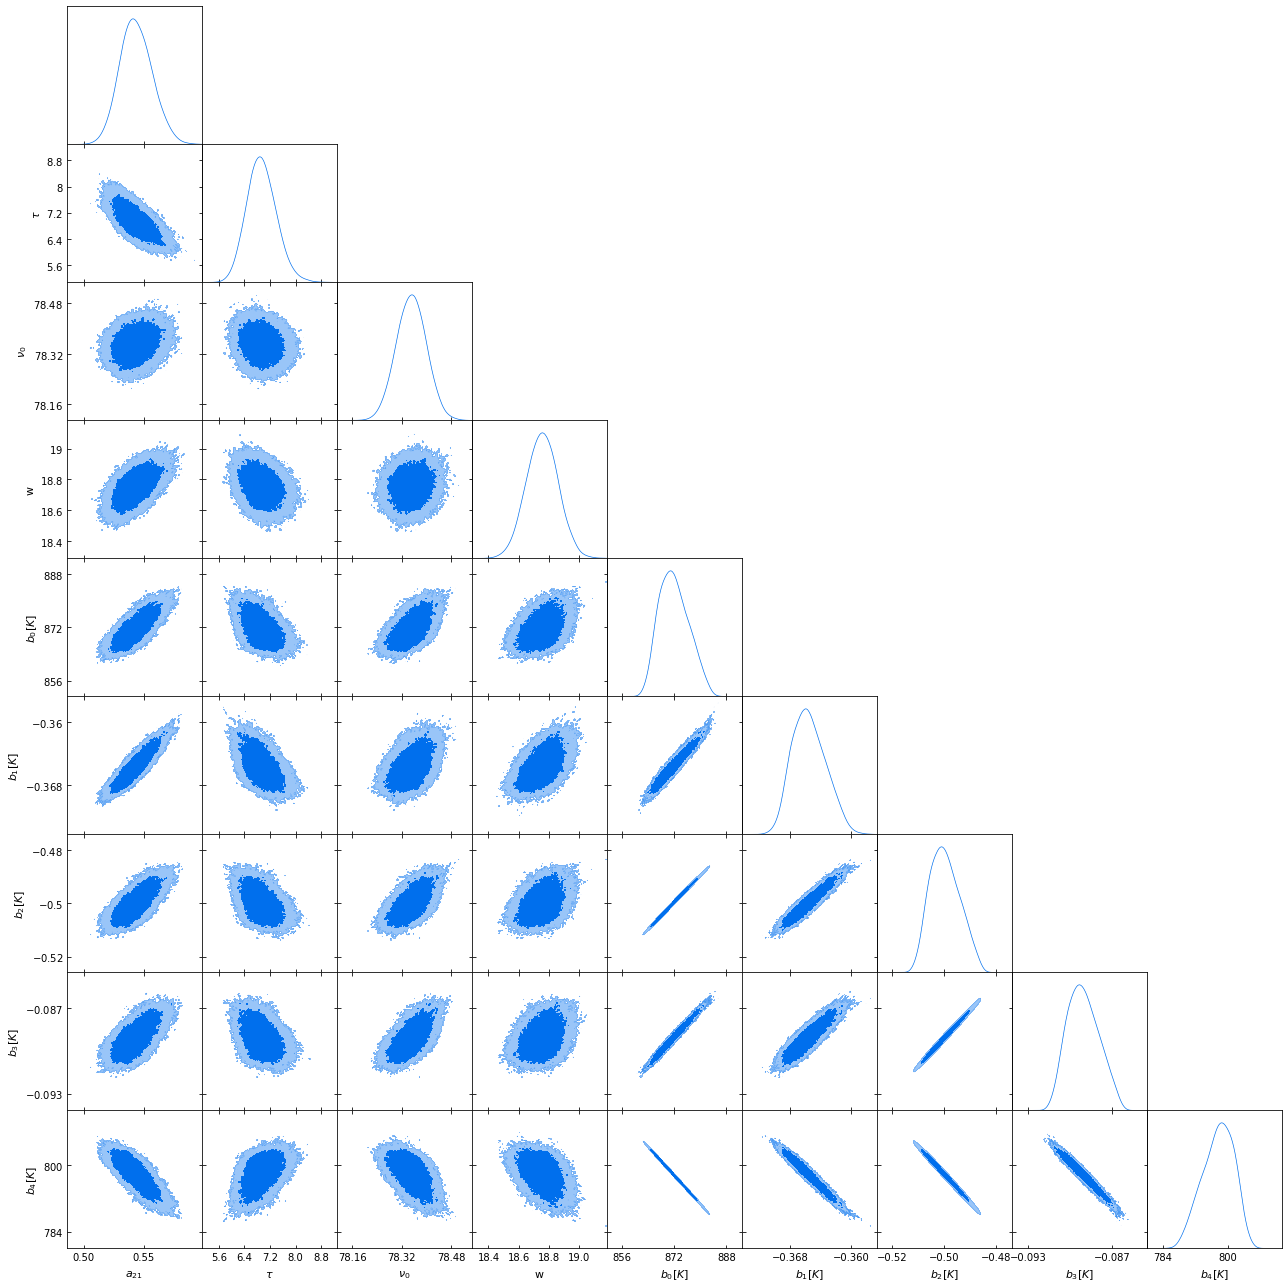

In [11]:
corner(sampler_phys_broad, lk_phys_broad, discard=1500, filled=True)

## Physical Foreground Model

In [22]:
lk_phys = MultiComponentSpectrumChi2(
    data = tsky,
    components = (
        AbsorptionProfile(freqs=freq),
        fg.PhysicalHills(freqs=freq)
    ),
    params = (
        Param("A", min=0, max=20, ref=norm(2, 0.1)),
        Param("tau", min=0, max=100, ref=norm(3.7, 0.5)),
        Param("nu0", min=60, max=120, ref=norm(90, 3)),
        Param("w", min=1, max=40, ref=norm(32, 2)),
        Param("b0", min=10, max=1e5, ref=norm(1755, 20)),
        Param("b1", min=-2, max=0, ref=norm(-.07, 0.01)),
        Param("b2", min=-0.1, max=0.1, ref=norm(-0.01, 0.01)),
        Param("b3", min=-0.02, max=0.2, ref=norm(0.005, 0.005)),
        Param("Te", min=200, max=2000, ref=norm(894, 20)),
    )
)

In [23]:
sampler_phys = run_mcmc(
    lk_phys, 
    sampler_kw = {"nwalkers":500, "threads":8},
    sampling_kw = {"nsteps":3000, "store":True, "progress":"notebook"}
)

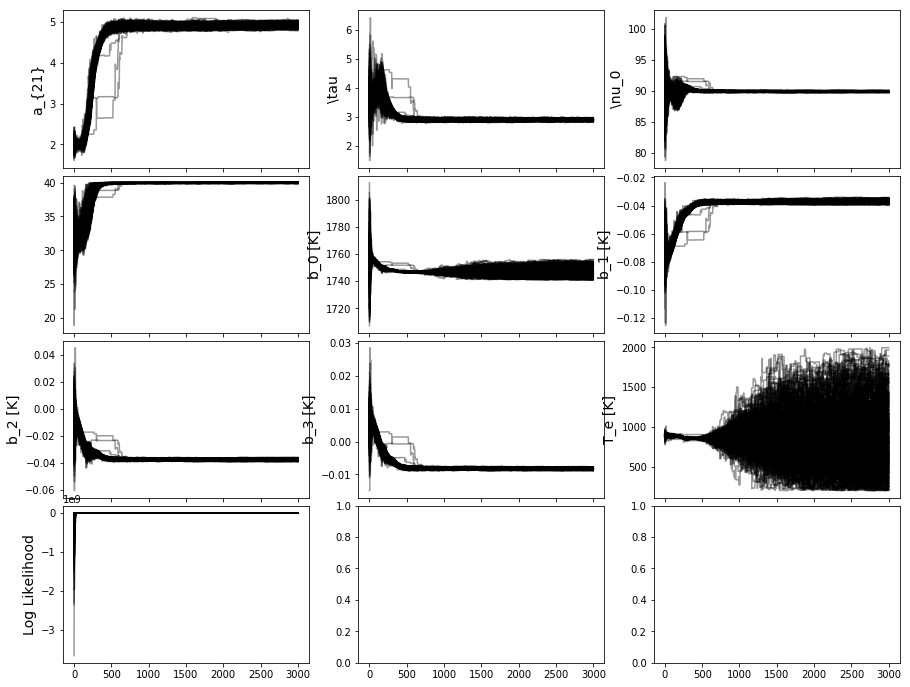

In [25]:
traceplot(sampler_phys, lk_phys)

Removed no burn in


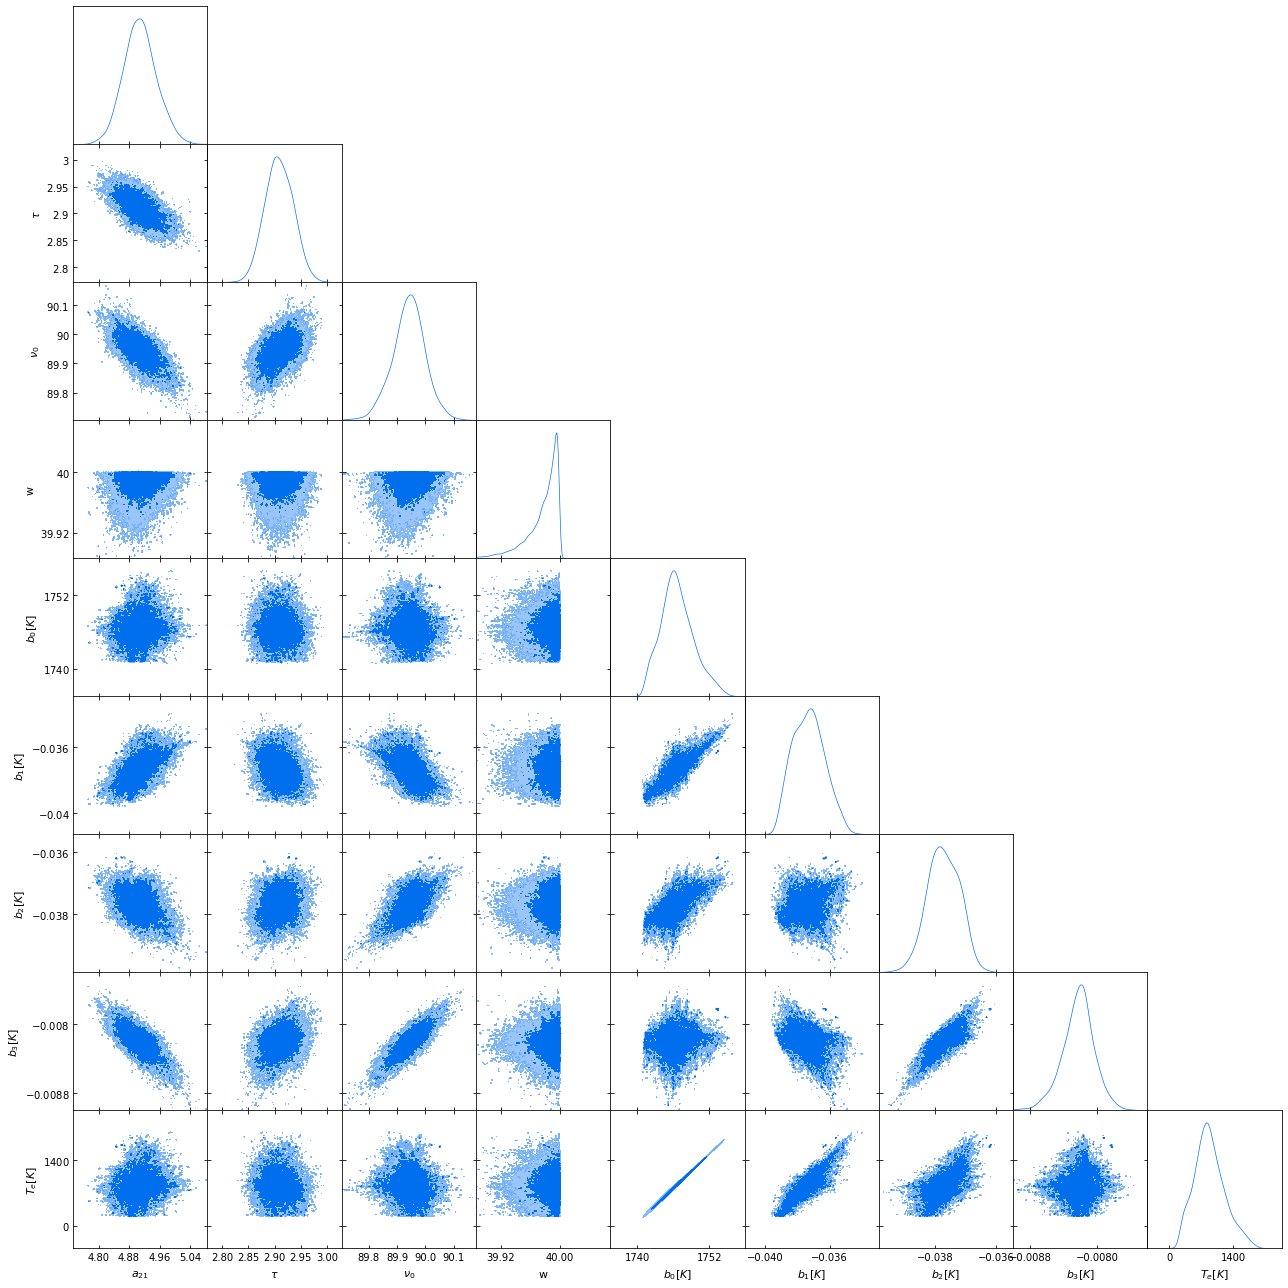

In [31]:
corner(sampler_phys, lk_phys, discard=1500, filled=True)

## Polynomial

In [7]:
fg.LinPoly._n = 5

lk_polynomial_full = MultiComponentSpectrumChi2(
    data = tsky,
    components = (
        AbsorptionProfile(freqs=freq),
        fg.LinPoly(freqs=freq)
    ),
    params = (
        Param("sigma", min=0, max=0.1),
        Param("A", min=0, max=20, ref=norm(1, 0.1)),
        Param("tau", min=0, max=100, ref=norm(3.4, 0.2)),
        Param("nu0", min=60, max=90, ref=norm(77.9, 3)),
        Param("w", min=1, max=40, ref=norm(19, 3)),
        Param("p0", min=0, max=1e5, ref=norm(2000, 20)),
        Param("p1", min=-1e5, max=1e5, ref=norm(-720, 20)),
        Param("p2", min=-1e5, max=1e5, ref=norm(987, 20)),
        Param("p3", min=-1e5, max=1e5, ref=norm(-695, 20)),
        Param("p4", min=-1e5, max=1e5, ref=norm(179, 20)),
    )
)

lk_polynomial_restrict = MultiComponentSpectrumChi2(
    data = tsky[freq>=60],
    components = (
        AbsorptionProfile(freqs=freq[freq>=60]),
        fg.LinPoly(freqs=freq[freq>=60])
    ),
    params = (
        Param("sigma", min=0, max=0.1),
        Param("A", min=0, max=20, ref=norm(0.5, 0.1)),
        Param("tau", min=0, max=100, ref=norm(6.88, 0.2)),
        Param("nu0", min=60, max=90, ref=norm(78, 3)),
        Param("w", min=1, max=40, ref=norm(19, 3)),
        Param("p0", min=0, max=1e5, ref=norm(1800, 20)),
        Param("p1", min=-1e5, max=1e5, ref=norm(78, 20)),
        Param("p2", min=-1e5, max=1e5, ref=norm(-191, 20)),
        Param("p3", min=-1e5, max=1e5, ref=norm(60, 20)),
        Param("p4", min=-1e5, max=1e5, ref=norm(1, 20)),
    )
)

fg.LinPoly._n = 6
lk_polynomial_full6 = MultiComponentSpectrumChi2(
    data = tsky,
    components = (
        AbsorptionProfile(freqs=freq),
        fg.LinPoly(freqs=freq)
    ),
    params = (
        Param("sigma", min=0, max=0.1),
        Param("A", min=0, max=20, ref=norm(1, 0.1)),
        Param("tau", min=0, max=100, ref=norm(3.4, 0.2)),
        Param("nu0", min=60, max=90, ref=norm(77.9, 3)),
        Param("w", min=1, max=40, ref=norm(19, 3)),
        Param("p0", min=0, max=1e5, ref=norm(2000, 20)),
        Param("p1", min=-1e5, max=1e5, ref=norm(-720, 20)),
        Param("p2", min=-1e5, max=1e5, ref=norm(987, 20)),
        Param("p3", min=-1e5, max=1e5, ref=norm(-695, 20)),
        Param("p4", min=-1e5, max=1e5, ref=norm(179, 20)),
        Param("p5", min=-1e5, max=1e5, ref=norm(0, 100)),
    )
)